In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold, KFold, cross_validate
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    auc,
    brier_score_loss,
    confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler

### Data cleaning & preprocessing

In [3]:
file_path = '/content/drive/MyDrive/cardio_train.csv'
cardio = pd.read_csv(file_path)
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
cardio['cardio'].value_counts()

,count
cardio,
0,35021
1,34979


In [5]:
df = cardio.copy()
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [7]:
df = df.drop(columns=['id'])
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [8]:
df.isnull().sum()

,0
age,0
gender,0
height,0
weight,0
ap_hi,0
ap_lo,0
cholesterol,0
gluc,0
smoke,0
alco,0


In [9]:
df.duplicated().sum()

np.int64(24)

In [10]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [11]:
df['age'] = df['age'] // 365

In [12]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [13]:
df['gender'] = df['gender'] - 1

In [14]:
df = pd.get_dummies(df, columns=['cholesterol', 'gluc'], drop_first=True, dtype=int)

In [15]:
df = df[(df['height'] >= 130) & (df['height'] <= 210)]
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]
df = df[(df['ap_hi'] >= 90) & (df['ap_hi'] <= 200)]
df = df[(df['ap_lo'] >= 60) & (df['ap_lo'] <= 130)]

In [16]:
df['bmi'] = df['weight'] / (df['height'] / 100) ** 2
df = df.drop(columns=['height', 'weight'])

In [17]:
df = df[(df['bmi'] >= 10) & (df['bmi'] <= 60)]
df.head()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_2,cholesterol_3,gluc_2,gluc_3,bmi
0,50,1,110,80,0,0,1,0,0,0,0,0,21.967120
1,55,0,140,90,0,0,1,1,0,1,0,0,34.927679
2,51,0,130,70,0,0,0,1,0,1,0,0,23.507805
3,48,1,150,100,0,0,1,1,0,0,0,0,28.710479
4,47,0,100,60,0,0,0,0,0,0,0,0,23.011177


In [18]:
df.describe()

,age,gender,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_2,cholesterol_3,gluc_2,gluc_3,bmi
count,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000,68307.000000
mean,52.832565,0.348866,126.656097,81.343113,0.087912,0.053406,0.803461,0.495001,0.135213,0.114747,0.073667,0.076098,27.436358
std,6.767236,0.476615,16.399579,9.266984,0.283169,0.224843,0.397384,0.499979,0.341954,0.318718,0.261231,0.265156,5.164184
min,29.000000,0.000000,90.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.726644
25%,48.000000,0.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.875115
50%,53.000000,0.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.346494
75%,58.000000,1.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,30.116213
max,64.000000,1.000000,200.000000,130.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,59.523810


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68307 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            68307 non-null  int64  
 1   gender         68307 non-null  int64  
 2   ap_hi          68307 non-null  int64  
 3   ap_lo          68307 non-null  int64  
 4   smoke          68307 non-null  int64  
 5   alco           68307 non-null  int64  
 6   active         68307 non-null  int64  
 7   cardio         68307 non-null  int64  
 8   cholesterol_2  68307 non-null  int64  
 9   cholesterol_3  68307 non-null  int64  
 10  gluc_2         68307 non-null  int64  
 11  gluc_3         68307 non-null  int64  
 12  bmi            68307 non-null  float64
dtypes: float64(1), int64(12)
memory usage: 7.3 MB


In [20]:
df['cardio'].value_counts()

,count
cardio,
0,34495
1,33812


In [21]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
# Prepare features for VIF
X = df.drop(columns=['cardio'])  # exclude target variable
X_const = add_constant(X)

# Calculate VIF
vif_df = pd.DataFrame()
vif_df["feature"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

vif_df.sort_values(by="VIF", ascending=False)

,feature,VIF
0,const,139.567664
3,ap_hi,2.241749
4,ap_lo,2.154855
9,cholesterol_3,1.391361
11,gluc_3,1.315419
5,smoke,1.247315
2,gender,1.160324
6,alco,1.139728
12,bmi,1.129576
8,cholesterol_2,1.124601


### EDA

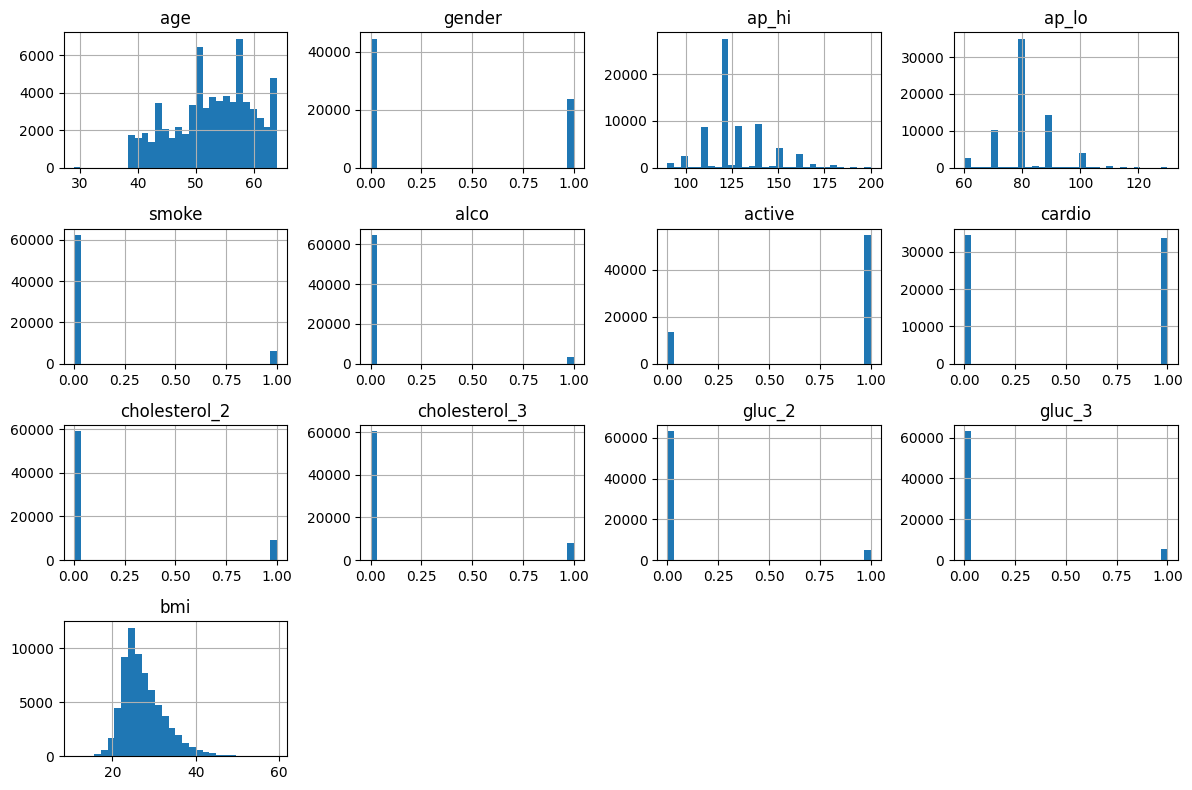

In [22]:
# Histograms for numerical columns
df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

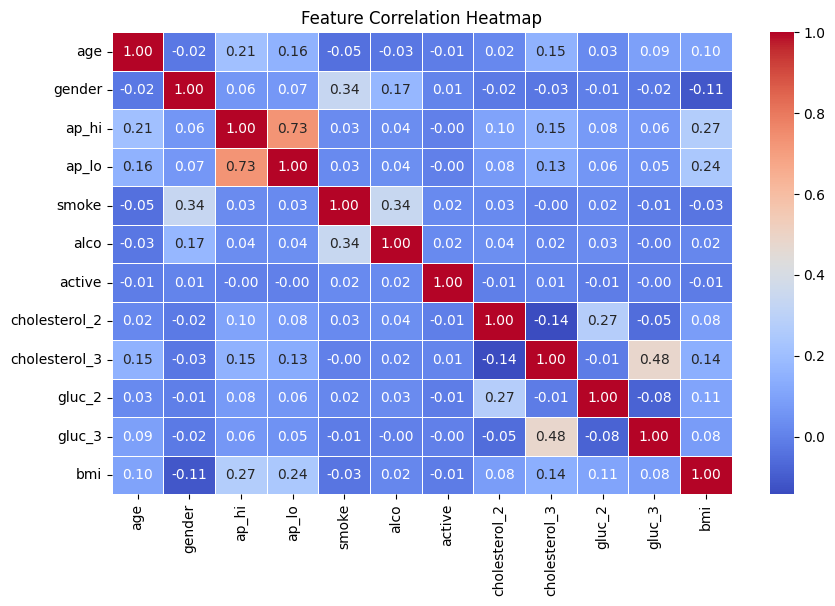

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.drop('cardio', axis=1).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

### XGboost model

Finding the best weights

In [24]:
# Define features and target variable
X = df.drop(columns=['cardio'])
y = df['cardio']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define different weight ratios
weights = [(1,2), (2,3), (3,4), (4,5)]

# Initialize base model configuration
base_model_params = {
    'learning_rate': 0.05,
    'n_estimators': 300,
    'max_depth': 4,
    'min_child_weight': 2,
    'gamma': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'enable_categorical': True
}

# Store performance for different weight ratios
weight_performance = {}

# First, train and evaluate base model without weight adjustment
base_model = xgb.XGBClassifier(**base_model_params)
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

# Store base model performance
weight_performance['Base Model'] = {
    'accuracy': accuracy_score(y_test, base_predictions),
    'precision': precision_score(y_test, base_predictions),
    'recall': recall_score(y_test, base_predictions),
    'f1_score': f1_score(y_test, base_predictions)
}

# Train and evaluate model with different weights
for positive_class_weight, negative_class_weight in weights:
    # Copy base model parameters and add current weight
    model_params = base_model_params.copy()
    model_params['scale_pos_weight'] = negative_class_weight / positive_class_weight

    # Create model
    model = xgb.XGBClassifier(**model_params)

    # Train model
    model.fit(X_train, y_train)

    # Predict
    y_predictions = model.predict(X_test)

    # Calculate performance metrics
    weight_performance[f"{positive_class_weight}:{negative_class_weight}"] = {
        'accuracy': accuracy_score(y_test, y_predictions),
        'precision': precision_score(y_test, y_predictions),
        'recall': recall_score(y_test, y_predictions),
        'f1_score': f1_score(y_test, y_predictions)
    }

Model Performance with Different Weights:
            accuracy  precision    recall  f1_score
Base Model  0.740814   0.761356  0.693923  0.726077
1:2         0.706339   0.656538  0.853024  0.741994
2:3         0.729322   0.704633  0.780275  0.740528
3:4         0.735031   0.722309  0.754990  0.738288
4:5         0.737740   0.731981  0.741831  0.736873


<Figure size 1200x600 with 0 Axes>

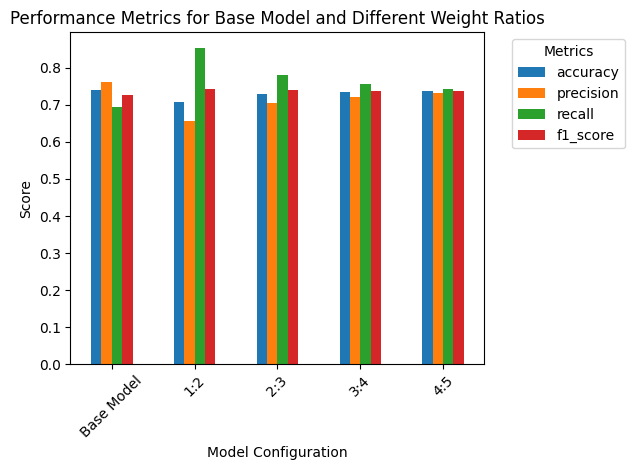


Changes from Base Model:

Weight Ratio 1:2:
  Accuracy Change: -0.0345
  Precision Change: -0.1048
  Recall Change: 0.1591
  F1 Score Change: 0.0159

Weight Ratio 2:3:
  Accuracy Change: -0.0115
  Precision Change: -0.0567
  Recall Change: 0.0864
  F1 Score Change: 0.0145

Weight Ratio 3:4:
  Accuracy Change: -0.0058
  Precision Change: -0.0390
  Recall Change: 0.0611
  F1 Score Change: 0.0122

Weight Ratio 4:5:
  Accuracy Change: -0.0031
  Precision Change: -0.0294
  Recall Change: 0.0479
  F1 Score Change: 0.0108


In [25]:
# Create performance comparison table
performance_dataframe = pd.DataFrame(weight_performance).T
print("Model Performance with Different Weights:")
print(performance_dataframe)

# Optional: Visualize performance comparison
plt.figure(figsize=(12, 6))
performance_dataframe.plot(kind='bar', rot=45)
plt.title('Performance Metrics for Base Model and Different Weight Ratios')
plt.xlabel('Model Configuration')
plt.ylabel('Score')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Optional: Detailed comparison of changes from base model
print("\nChanges from Base Model:")
for model_name, metrics in weight_performance.items():
    if model_name != 'Base Model':
        print(f"\nWeight Ratio {model_name}:")
        for metric in ['accuracy', 'precision', 'recall', 'f1_score']:
            change = metrics[metric] - weight_performance['Base Model'][metric]
            print(f"  {metric.replace('_', ' ').title()} Change: {change:.4f}")

In [26]:
# Enhanced XGBoost Model
# Data Preparation
X = df.drop(['cardio'], axis=1)
y = df['cardio']


In [27]:
# 1. Cross Validation
# Using StratifiedKFold to maintain class distribution
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [28]:
# 2. Compute class weights to improve recall

# Define XGBoost Model with class weights
xgb_model = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=3 / 2
)

# Create Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define Multiple Evaluation Metrics
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Perform Cross-Validation
cv_results = cross_validate(
    xgb_model,
    X,
    y,
    cv=cv,
    scoring=scoring
)

# Print Cross-Validation Results
print("Cross-Validation Results:")
for metric, scores in cv_results.items():
    if metric.startswith('test_'):
        print(f"{metric[5:].capitalize()} - Mean: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Model Training
xgb_model.fit(X_train, y_train)

Cross-Validation Results:
Accuracy - Mean: 0.7259 (+/- 0.0095)
Precision - Mean: 0.7015 (+/- 0.0095)
Recall - Mean: 0.7769 (+/- 0.0121)
F1 - Mean: 0.7373 (+/- 0.0091)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

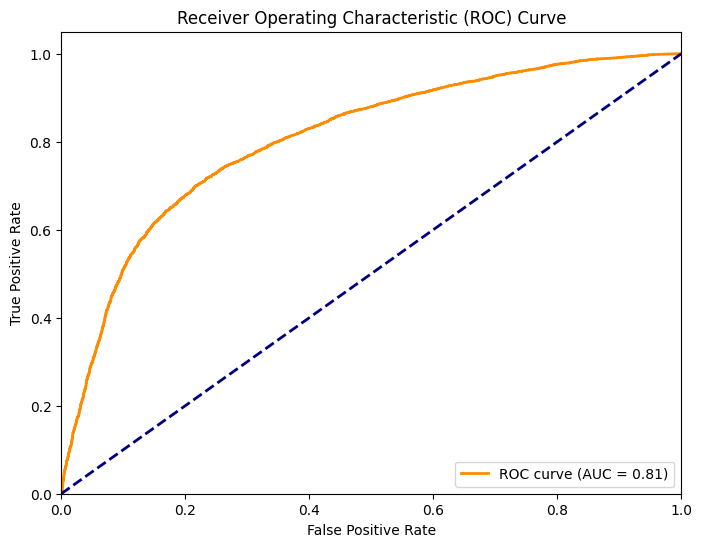

In [29]:
# 3. ROC Curve
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [30]:
# 4. Brier Score (measures prediction probability calibration)
brier_score = brier_score_loss(y_test, y_pred_proba)
print(f"\nBrier Score: {brier_score:.4f}")

# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance.to_string(index=False))


Brier Score: 0.1842

Feature Importance:
      feature  importance
        ap_hi    0.523930
cholesterol_3    0.171999
          age    0.085516
       active    0.034331
cholesterol_2    0.032491
        ap_lo    0.029224
       gluc_3    0.026222
        smoke    0.022907
          bmi    0.022054
         alco    0.019686
       gluc_2    0.017185
       gender    0.014454
